In [23]:
from sklearn import cross_validation, svm

from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix , recall_score , roc_curve , roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from matplotlib.font_manager import FontProperties
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import sys
sys.path.append('c:/pjt/QuantFin-Equity/source/libs/')
from libs import General ,PlotFunctions , DataAcquisition

from matplotlib import  style
import matplotlib.pyplot as plt
import seaborn as sns
import statistics


import pandas as pd
import numpy as np

style.use('dark_background')

In [7]:
def get_features(features=['P/B ratio',
                          'ROE'],dropna=True, local=True, con_man=True):
    
    sscaller = StandardScaler()
    if local:
        df = DataAcquisition.get_data_local(con_man=con_man)
    else:
        df = DataAcquisition.get_data_sql()
    if dropna:
        df = df.replace('None',np.nan).replace(-99999.00,np.nan).replace(-1,np.nan).dropna(axis=0)
        df.dropna(how='any',inplace=True)
    

    y = np.array(df['Absolute_Stock_Perfomance_Flag'])
    Z = df[['Stock_Future_Pefomance','SNP500_Future_Perfomance']]
    df = df[features]
    df = pd.concat([df,Z],axis=1)
    df = df.astype(float)
    X = np.array(df.values)
    
    X = sscaller.fit_transform(X)
    return X, y


def get_dummy(X,y):
    strategy = ['stratified','most_frequent','uniform']

    for start in strategy:
        dummyc = DummyClassifier(strategy=start)
        dummyc.fit(X,y)
        print(start,': Dummy Score:',round(dummyc.score(X,y),2))


def run_backtest(y,y_p,Z):
    invest_amount = 1000
    stock_return = []
    index_return = []
    for i in range(Z.shape[0]):
        if y_p[i]==1:
            inv_return = invest_amount + (invest_amount*Z[i,0])
            stock_return.append(inv_return)
        else:
            inv_return = invest_amount + (invest_amount*Z[i,1])
            index_return.append(inv_return)

    return [{'Mean Stock Retun': statistics.mean(stock_return),
            'Sum Stock Return' : sum(stock_return)},
            {'Mean SnP Return ': statistics.mean(index_return),
            'Sum SnP Return' :  sum(index_return)} ]

X,y  = get_features()

In [8]:
X

array([[ 0.78429191,  0.53871595, -0.01475404,  0.93930897],
       [ 0.98210054,  0.43546148, -0.01290461,  0.74766185],
       [ 0.59508366,  0.18526794, -0.00962836,  1.10160913],
       ...,
       [-1.30559924, -0.96244525, -0.01056464,  0.91364543],
       [-0.97018461, -1.11732696, -0.01218296,  0.38493343],
       [-1.02178686, -1.18881083, -0.01324425,  0.43430937]])

In [9]:
get_dummy(X,y)

stratified : Dummy Score: 0.59
most_frequent : Dummy Score: 0.7
uniform : Dummy Score: 0.51


In [19]:
#'''First Run - Simple rules'''
###############


######RUN CODE###

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X,y, test_size=0.4)

X_train = X_train[:,:-2]
Z_train = X_train[:,-2:]

X_test = X_test[:,:-2]
Z_test = X_test[:,-2:]

#%%
clf = svm.SVC()
#clf = LogisticRegression()
clf.fit(X_train,Y_train)


clf.fit(X_train,Y_train)
print('SVM Score:\n',round(clf.score(X_test,Y_test),3))
y_predict = clf.predict(X_test)


SVM Score:
 0.694


In [ ]:
#Grid Search
C_range = list(range(1,150,10))
param_grid= dict(C=C_range)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy',n_jobs=-1)
grid.fit(X, y)


means = []
for i in grid.grid_scores_:
    means.append(i.mean_validation_score)



Best Accuracy:  0.7184074366394808
Best Parameter:  {'C': 121}


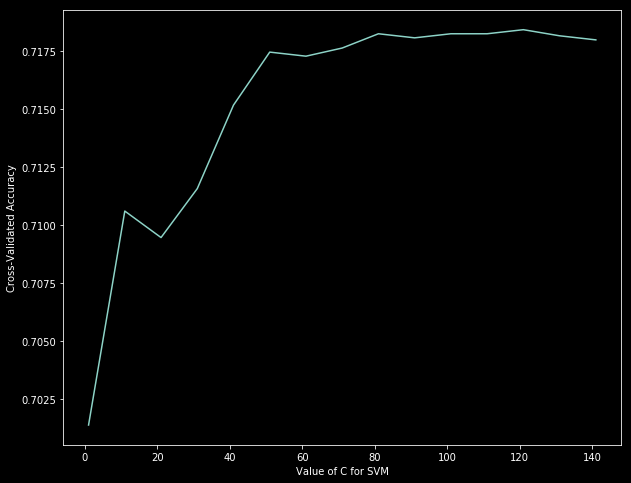

In [29]:
plt.figure(figsize=(10,8))
plt.plot(C_range,means);
plt.xlabel('Value of C for SVM')
plt.ylabel('Cross-Validated Accuracy')
print('Best Accuracy: ',grid.best_score_)
print('Best Parameter: ',grid.best_params_)

In [ ]:
print('Run Backtest:')
run_backtest(Y_test,y_predict,Z_test)